In [1]:
%load_ext autoreload
%autoreload 2
from calibrate import *
import matplotlib.pyplot as plt
import numpy as np
import skimage

In [48]:
master_bias('/home/felix/PiCamera_DSLR_like_controller/calibration/Bias', '/home/felix/PiCamera_DSLR_like_controller/calibration/computed')
mbias = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_bias.npy')/(2**16-1)*255


In [ ]:
plt.plot(mbias/(2**16-1)*255)

In [4]:
master_flat(img_dir='/home/felix/PiCamera_DSLR_like_controller/calibration/Flats',out_dir='/home/felix/PiCamera_DSLR_like_controller/calibration/computed', mbias='/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_bias.npy',mdark=None)
mflat = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_flat.npy')


In [ ]:
plt.plot(mflat)

### Couldnt crack lens dist

# Image gen
(shitty)HDR first gives better results

In [4]:
img_dir = '/home/felix/Pictures/whiteboard_eraser'
# These are uint16
mflat = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_flat.npy')
mbias = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_bias.npy')/(2**16-1)*255
#os.mkdir(os.path.join(img_dir,'preprocessed'))
for i in os.listdir(img_dir):
    try:
        processed = (np.asarray(Image.open(os.path.join(img_dir, i))) - mbias)/mflat
        processed[processed>255] = 255
        processed[processed<0] = 0
        processed = processed.astype(np.uint8)
        Image.fromarray(processed).save(os.path.join(img_dir,'preprocessed',i))
    except Exception as e:
        print('failed: ', e)
        print(i)

    


failed:  [Errno 21] Is a directory: '/home/felix/Pictures/whiteboard_eraser/preprocessed'
preprocessed


In [5]:
img_dir = '/home/felix/Pictures/whiteboard_eraser'
gray_projection = 'l-star'
contrast_window_size = 50
contrast_edge_scale = 0
os.chdir(os.path.join(img_dir,'preprocessed'))
for i in range(0,3):
    cmd = 'enfuse -o result_{}.tiff --exposure-weight=0 --saturation-weight=0 --contrast-weight=1 --hard-mask --gray-projector={} --contrast-window-size={} --contrast-edge-scale=-0.1 *_{}.png'.format(i,gray_projection,contrast_window_size,i)
    os.system(cmd)

enfuse: warning: contrast window size "50" is even; increasing size to next odd number
enfuse: info: input image "05142023-02:51:04_0.png" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "05142023-02:52:44_0.png" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "05142023-02:53:27_0.png" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "05142023-02:53:45_0.png" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "05142023-02:54:41_0.png" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "05142023-02:55:16_0.png" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to

In [9]:
# Make HDR     _f so that it doesnt get read later
cmd = 'enfuse -o stack_hdr_f.tiff result_*.tiff'
os.system(cmd)

enfuse: info: loading next image: result_0.tiff 1/1
enfuse: info: loading next image: result_1.tiff 1/1
enfuse: info: loading next image: result_2.tiff 1/1


0

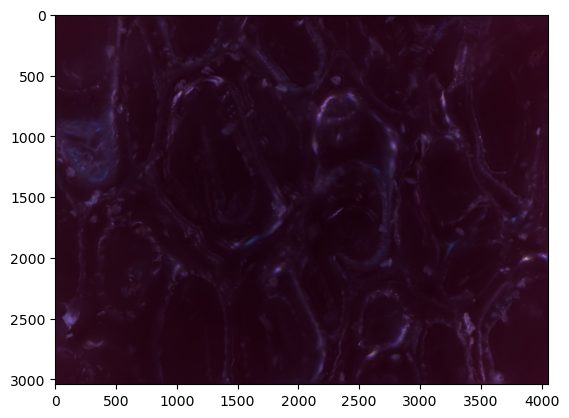

In [6]:
plt.imshow(Image.open(os.path.join(img_dir,'preprocessed','result_0.tiff')))

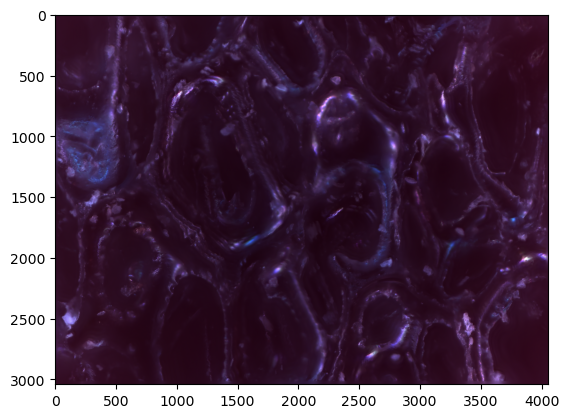

In [7]:
plt.imshow(Image.open(os.path.join(img_dir,'preprocessed','result_1.tiff')))

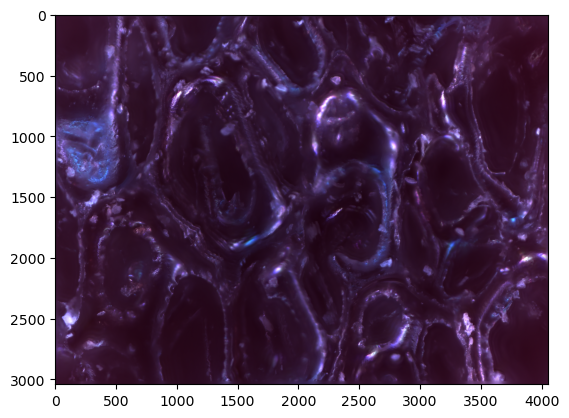

In [8]:
plt.imshow(Image.open(os.path.join(img_dir,'preprocessed','result_2.tiff')))

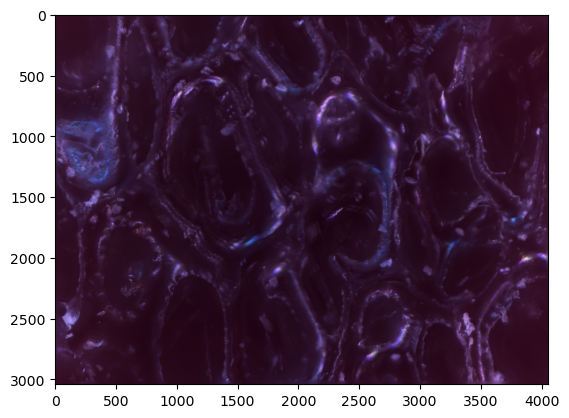

In [10]:
plt.imshow(Image.open(os.path.join(img_dir,'preprocessed','stack_hdr_f.tiff')))

In [11]:
# Make HDR then focus stack
os.chdir(os.path.join(img_dir,'preprocessed'))
filenames = {}
for i in os.listdir('.'):
    filenames[i.split('_')[0]] = 1
for key in filenames:
    # Make HDR for each
    cmd = 'enfuse -o {}_hdr.tiff {}*.png'.format(key,key)
    os.system(cmd)

enfuse: info: input image "05142023-02:53:45_0.png" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "05142023-02:53:45_1.png" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "05142023-02:53:45_2.png" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: warning: no usable resolution found in first image "05142023-02:53:45_0.png";
enfuse: note: Enfuse will assume 300 dpi
enfuse: info: loading next image: 05142023-02:53:45_0.png 1/1
enfuse: info: loading next image: 05142023-02:53:45_1.png 1/1
enfuse: info: loading next image: 05142023-02:53:45_2.png 1/1
enfuse: info: input image "05142023-02:58:20_0.png" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "05142023-02:58:20_1.png" does not have a

In [16]:
# Focus stack
gray_projection = 'l-star'
contrast_window_size = 50
contrast_edge_scale = 0.2
cmd = 'enfuse -o hdr_result_2f.tiff --exposure-weight=0 --saturation-weight=0 --contrast-weight=1 --hard-mask --gray-projector={} --contrast-window-size={} --contrast-edge-scale=-0.1 *_hdr.tiff'.format(gray_projection,contrast_window_size,i)
os.system(cmd)

enfuse: warning: contrast window size "50" is even; increasing size to next odd number
enfuse: info: loading next image: 05142023-02:51:04_hdr.tiff 1/1
enfuse: info: loading next image: 05142023-02:52:44_hdr.tiff 1/1
enfuse: info: loading next image: 05142023-02:53:27_hdr.tiff 1/1
enfuse: info: loading next image: 05142023-02:53:45_hdr.tiff 1/1
enfuse: info: loading next image: 05142023-02:54:41_hdr.tiff 1/1
enfuse: info: loading next image: 05142023-02:55:16_hdr.tiff 1/1
enfuse: info: loading next image: 05142023-02:55:44_hdr.tiff 1/1
enfuse: info: loading next image: 05142023-02:56:20_hdr.tiff 1/1
enfuse: info: loading next image: 05142023-02:56:57_hdr.tiff 1/1
enfuse: info: loading next image: 05142023-02:57:16_hdr.tiff 1/1
enfuse: info: loading next image: 05142023-02:57:39_hdr.tiff 1/1
enfuse: info: loading next image: 05142023-02:58:20_hdr.tiff 1/1
enfuse: info: loading next image: 05142023-02:58:40_hdr.tiff 1/1
enfuse: info: loading next image: 05142023-02:59:13_hdr.tiff 1/1
enf

0

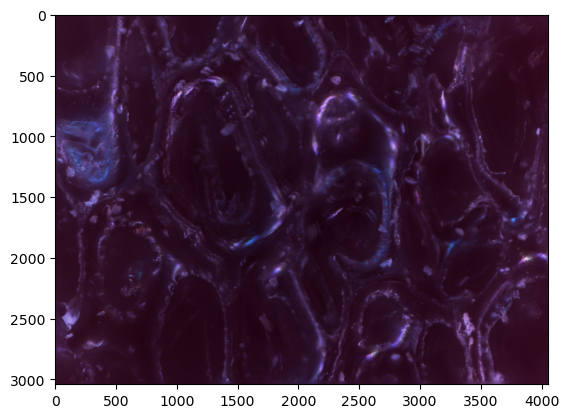

In [17]:
plt.imshow(Image.open(os.path.join(img_dir,'preprocessed','hdr_result_2f.tiff')))


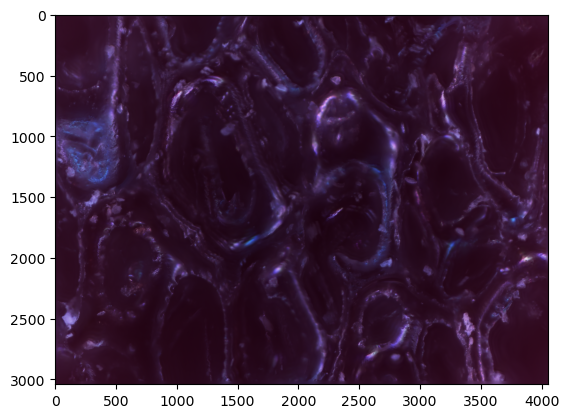

In [13]:
plt.imshow(Image.open(os.path.join(img_dir,'preprocessed','hdr_result_f.tiff')))